In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, kruskal, spearmanr

sns.set_context('talk')
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_style('whitegrid')

# Alpha diversity analysis

Analysis of alpha diversity from the Kraken layer rarefied to 2.5 million reads per sample. Look for changes over time and associations with vaccine titer.

## Read in data

Get metadata and kraken abundances. Kraken abundances were already split by taxonomy level in a previous notebook.

### Read in metadata

In [2]:
meta = pd.read_csv('../../data/metadata/stool/stool_metadata.csv', index_col='SampleID')
meta = pd.concat([meta,
                  pd.read_csv('../../data/metadata/stool/stool_abx_usage.csv', index_col='SampleID'),
                  pd.read_csv('../../data/metadata/stool/stool_titers_yr1.csv', index_col='SampleID'),
                  pd.read_csv('../../data/stool/kraken_alpha_diversity.csv', index_col='SampleID')],
                 axis=1)
meta = meta.query('`gt_2.5` == True')
meta = meta.loc[[i for i in meta.index if not (i.startswith('GD5_') or i.startswith('MSA2002_'))]]
meta['VR_group'] = meta['VR_group'].fillna('Not Measured')
meta = meta.sort_values(['BabyN', 'age_at_collection'])
meta.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group,genus_shannon,genus_evenness,genus_richness,species_shannon,species_evenness,species_richness
SampleID,,,,,,,,,,,,,,,,,,,,,
101_V3,Primary in Tube,701.0,NaN,NaN,Box23,Stool,Human Infant,MetaG,101.0,NaN,...,NaN,NaN,NaN,Not Measured,2.109696,0.016938,198,2.262752,0.007418,473
101_S1,Primary in Tube,707.0,NaN,NaN,Box23,Stool,Human Infant,MetaG,101.0,NaN,...,NaN,NaN,NaN,Not Measured,2.643140,0.018906,262,2.808873,0.006941,617
101_V5,Primary in Tube,704.0,NaN,NaN,Box23,Stool,Human Infant,MetaG,101.0,NaN,...,NaN,NaN,NaN,Not Measured,2.746375,0.020761,267,2.860439,0.007530,619
102_V1,Primary in Tube,700.0,NaN,NaN,Box23,Stool,Human Infant,MetaG,102.0,NaN,...,NaN,NaN,NaN,Not Measured,2.418361,0.023815,176,2.745093,0.012174,338
102_V3,Primary in Tube,708.0,NaN,NaN,Box23,Stool,Human Infant,MetaG,102.0,NaN,...,NaN,NaN,NaN,Not Measured,1.879383,0.019470,137,3.176577,0.025663,266


In [3]:
visit_codes = [i for i in meta['VisitCode'] if i.startswith('V') and '_' not in i]

## Shannon diversity analysis

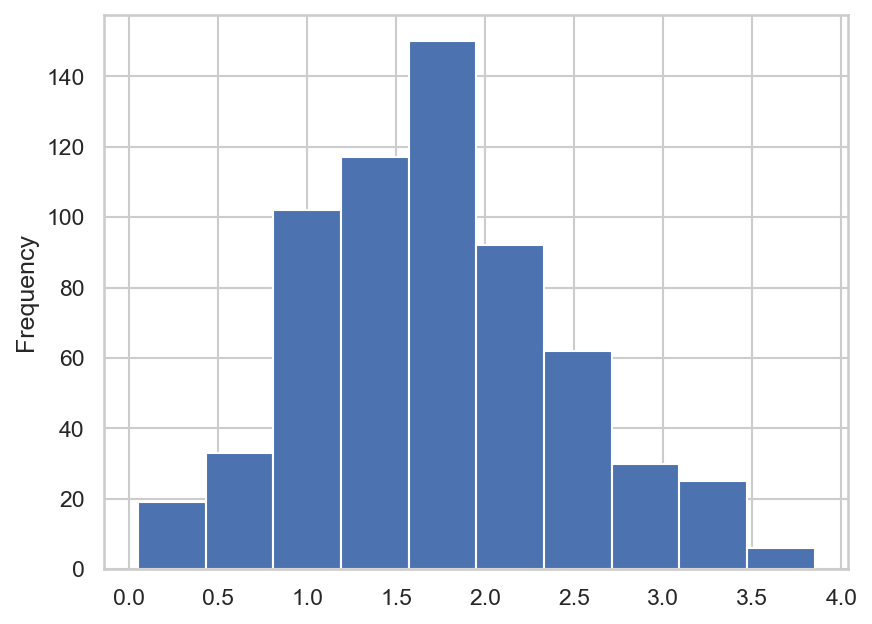

In [4]:
_ = meta['genus_shannon'].plot(kind='hist')

Histogram of shannon diversity values across all baby samples.

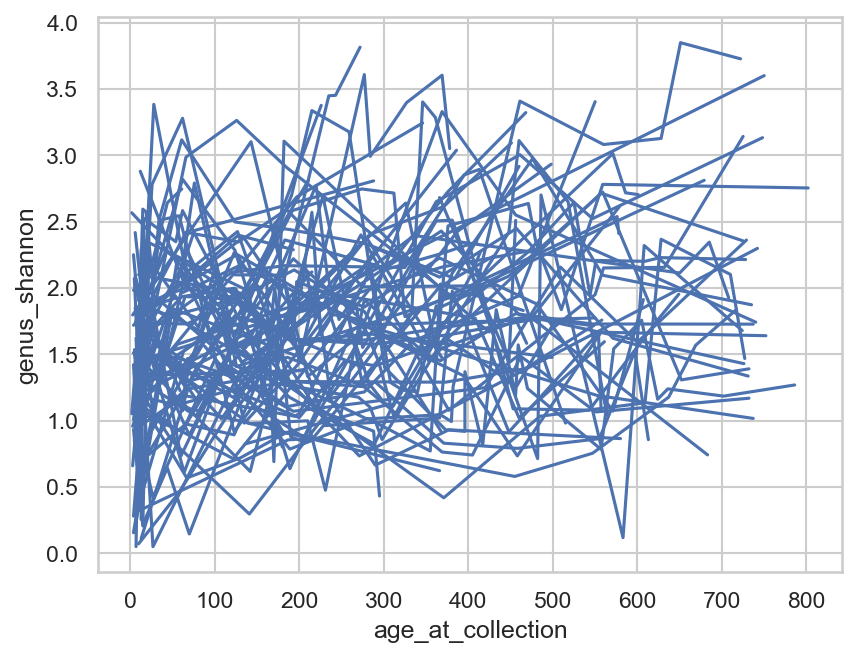

In [5]:
_ = sns.lineplot(x='age_at_collection', y='genus_shannon', units='BabyN', estimator=None, markers=True, data=meta)

So there is a general trend toward an increase of Shannon diversity over time but it is not super clear. REFERENCE R NOTEBOOK.

Calculate delta alpha diversity

In [6]:
baby_delta_frame = list()
for baby, baby_frame in meta.groupby('BabyN'):
    if baby_frame.shape[0] > 5:
        baby_frame = baby_frame.sort_values('age_at_collection')
        d_alpha_div = list(baby_frame['genus_shannon'].shift(-1) - baby_frame['genus_shannon'])[:-1]
        age_at_second_sample = list(baby_frame['age_at_collection'])[:-1]
        baby_delta_frame.append(pd.DataFrame([d_alpha_div, age_at_second_sample, [baby] * len(d_alpha_div)],
                                             index=['delta_alpha_div', 'age_at_second_sample', 'BabyN']).transpose())

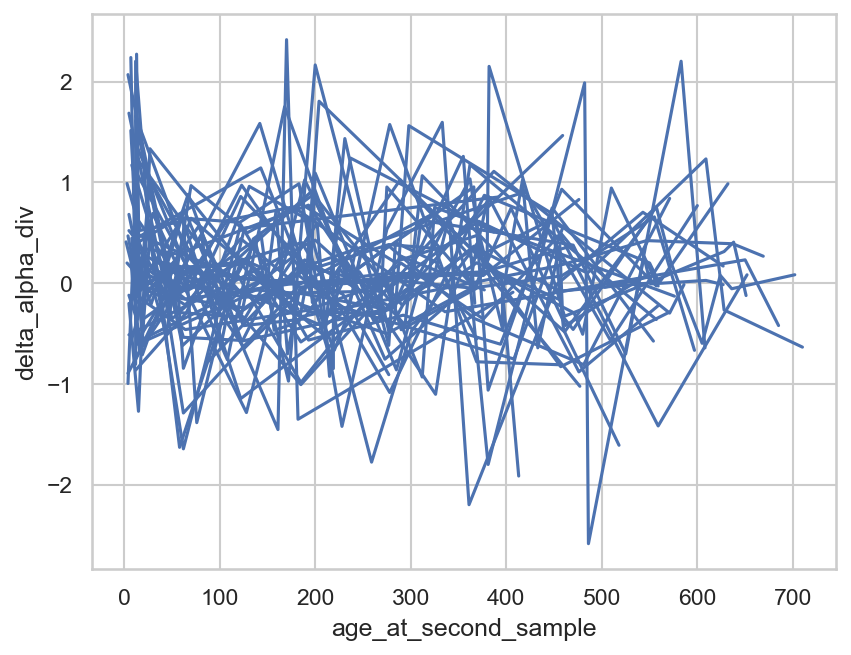

In [7]:
_ = sns.lineplot(x='age_at_second_sample', y='delta_alpha_div', units='BabyN', estimator=None, markers=True, data=pd.concat(baby_delta_frame).reset_index())

With an increase over time we would expect these values to be a bit above zero on average. This isn't a super clear trend.

To try to eliminate the variable of antibiotics lets pull out babies who never took antibiotics.

In [8]:
abx_usage = pd.read_csv('../../data/metadata/antibiotic_usage.tsv', sep='\t')
abx_usage.head()

,PrimaryKey,BabyN,AntibioticN,Name,Reason,Start_Date,End_Date,Duration_(days),DateOfBirth,AgeAtStart,AgeAtEnd,Route
0,Baby134_Antibiotic1,Baby134,1,piperacillin/ tazobactam,R/O sepsis,2018-11-26,2018-11-28,2,2018-11-22,4.0,6.0,IV
1,Baby134_Antibiotic2,Baby134,2,ampicillin,R/O sepsis,2018-11-26,2018-11-27,1,2018-11-22,4.0,5.0,IV
2,Baby134_Antibiotic3,Baby134,3,gentamicin,R/O sepsis,2018-11-26,2018-11-27,1,2018-11-22,4.0,5.0,IV
3,Baby134_Antibiotic4,Baby134,4,vancomycin,R/O sepsis,2018-11-26,2018-11-27,1,2018-11-22,4.0,5.0,IV
4,Baby235_Antibiotic1,Baby235,1,unknown anitbiotic(s),"R/O sepsis, later confirmed neg.",2018-06-19,Not Documented,Unknown,2018-06-13,6.0,NaN,NaN


In [9]:
babies_w_abx = [int(i.split('Baby')[-1]) for i in set(abx_usage['BabyN'])]

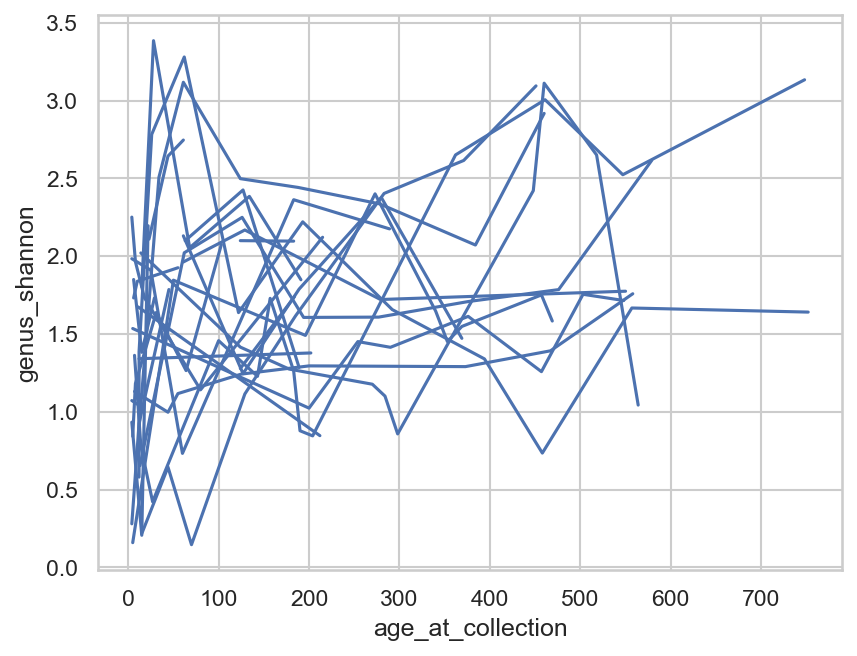

In [10]:
meta_no_abx = meta.loc[[i not in babies_w_abx for i in meta['BabyN']]]
_ = sns.lineplot(x='age_at_collection', y='genus_shannon', units='BabyN', estimator=None, markers=True, data=meta_no_abx)

Not really a clearer trend with antibiotics out of the picture.

To make the effect as obious as possible we can compare the V2 samples (7-13 days) to the V7 samples (6 months).

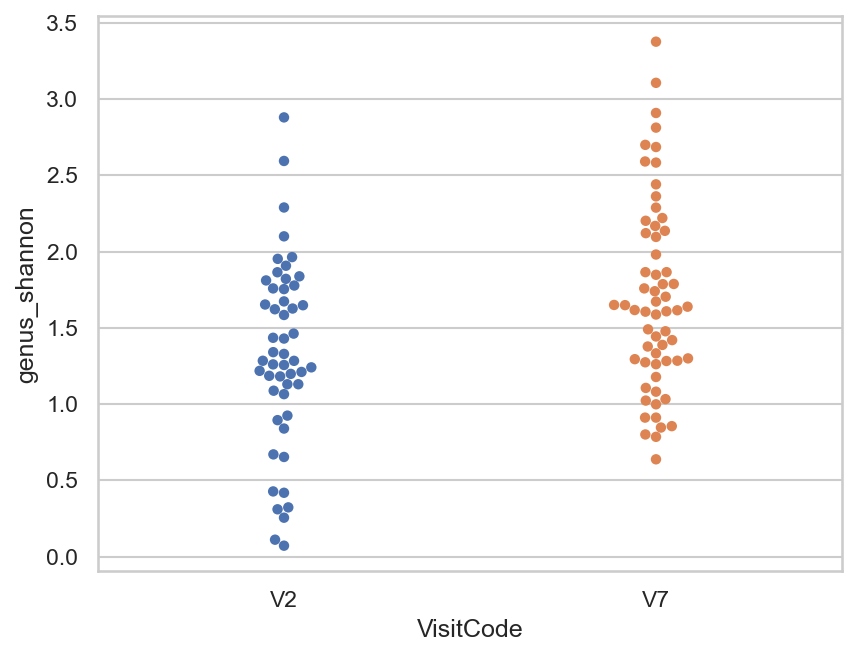

In [11]:
_ = sns.swarmplot(x='VisitCode', y='genus_shannon', data=meta.query("VisitCode in ['V2', 'V7']"))

So here we can see that there is a higher average diversity at 6 months than in the second week of life.

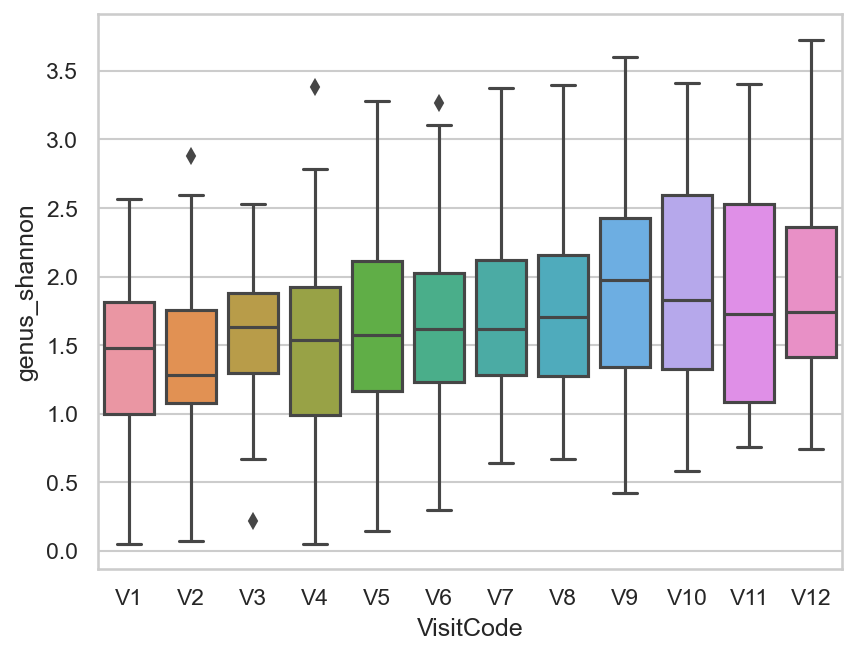

In [12]:
_ = sns.boxplot(x='VisitCode', y='genus_shannon', data=meta.query("VisitCode in @visit_codes").sort_values('age_at_collection'))

Now we can see the increase in median diversity up until around V9 (12 months).

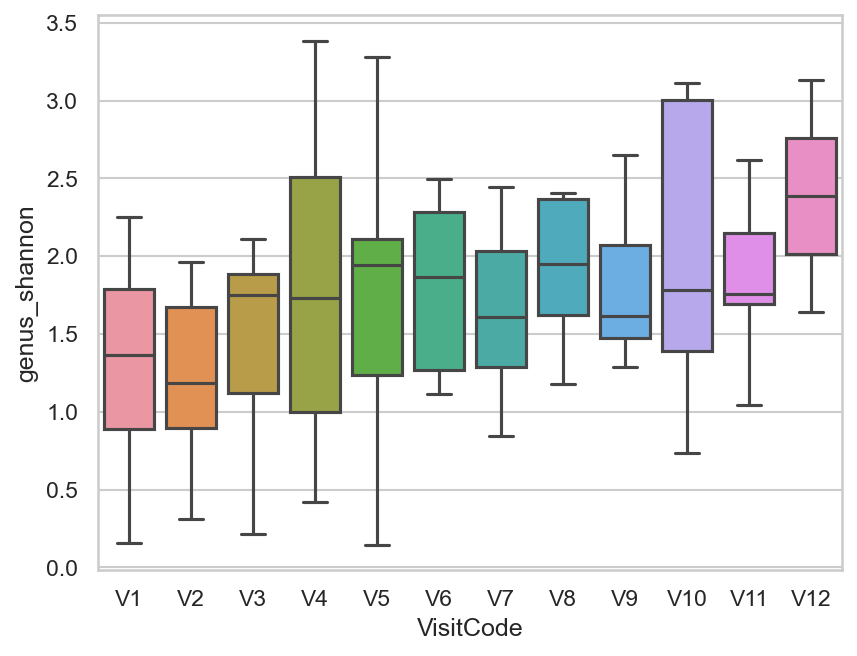

In [13]:
_ = sns.boxplot(x='VisitCode', y='genus_shannon', data=meta.query("VisitCode in @visit_codes").query("BabyN not in @babies_w_abx").sort_values('age_at_collection'))

Seems noiser when we remove samples where the baby had taken antibiotics. Smaller samples size so probably more noise.

In [14]:
meta_no_nas = meta.loc[~pd.isna(meta['age_at_collection']) & ~pd.isna(meta['genus_shannon'])]
pearsonr(meta_no_nas['age_at_collection'], meta_no_nas['genus_shannon'])

PearsonRResult(statistic=0.22720542273519953, pvalue=7.038379963346813e-09)

So a weak but significant correlation between age and shannon index when we ignore the lack of independence between samples from the same baby.

## Simpson E

Now we will look at evenness of communities.

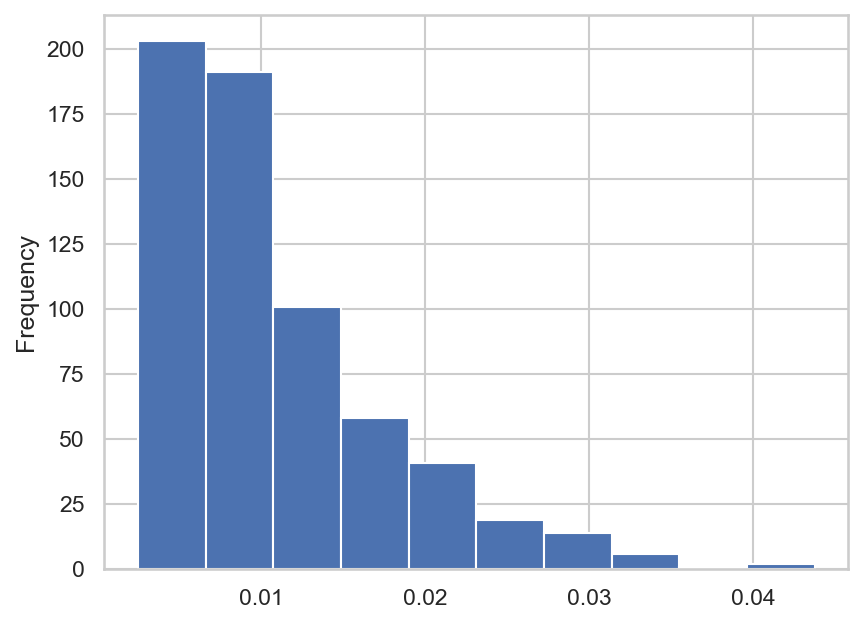

In [15]:
_ = meta['genus_evenness'].plot(kind='hist')

Heavy tail distribution.

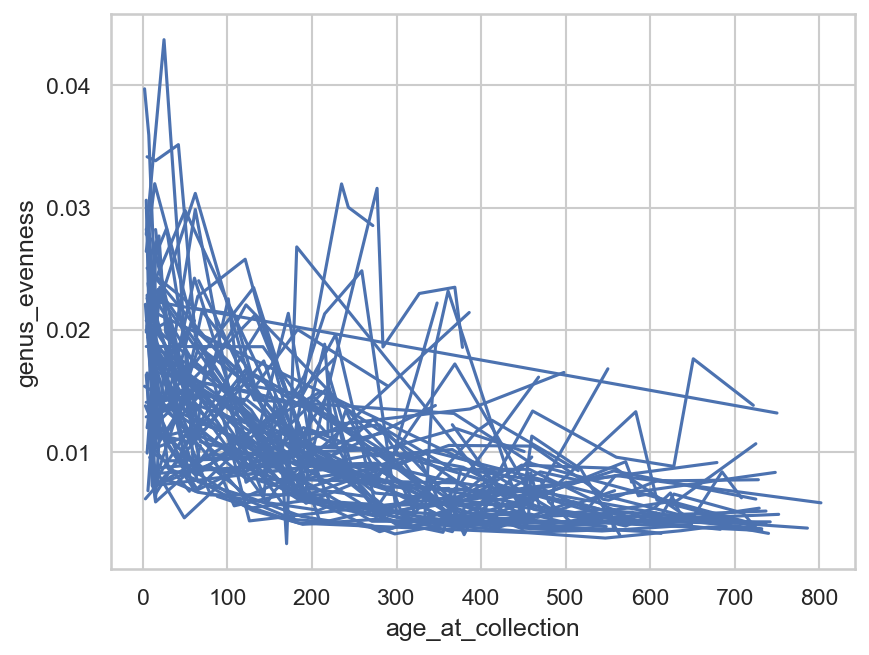

In [16]:
_ = sns.lineplot(x='age_at_collection', y='genus_evenness', units='BabyN', estimator=None, markers=True, data=meta)

Definitely seems to go down over time.

## Number of OTUs

Number of OTUs is really number of genuses. This is a measure of richness.

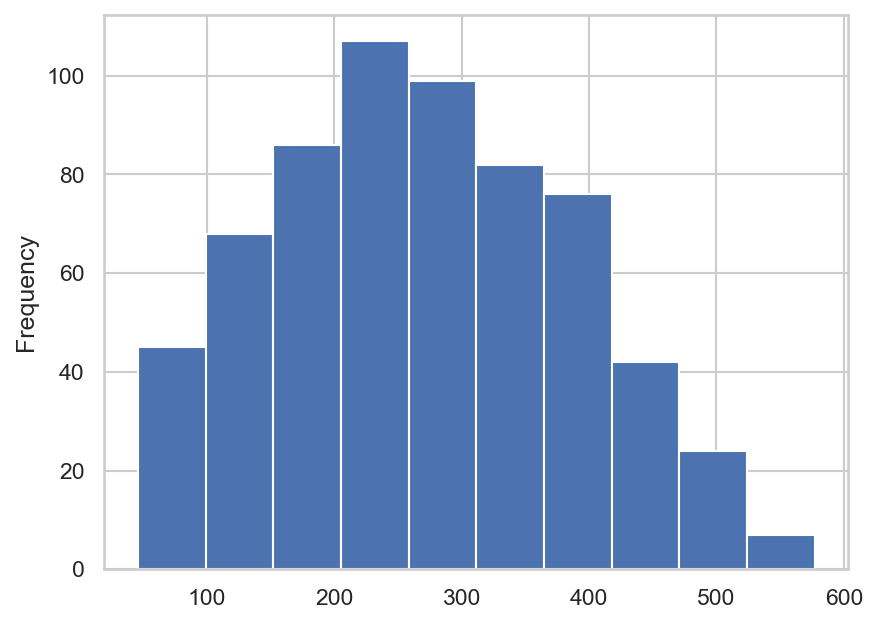

In [17]:
_ = meta['genus_richness'].plot(kind='hist')

Much more normal distribution than eveness.

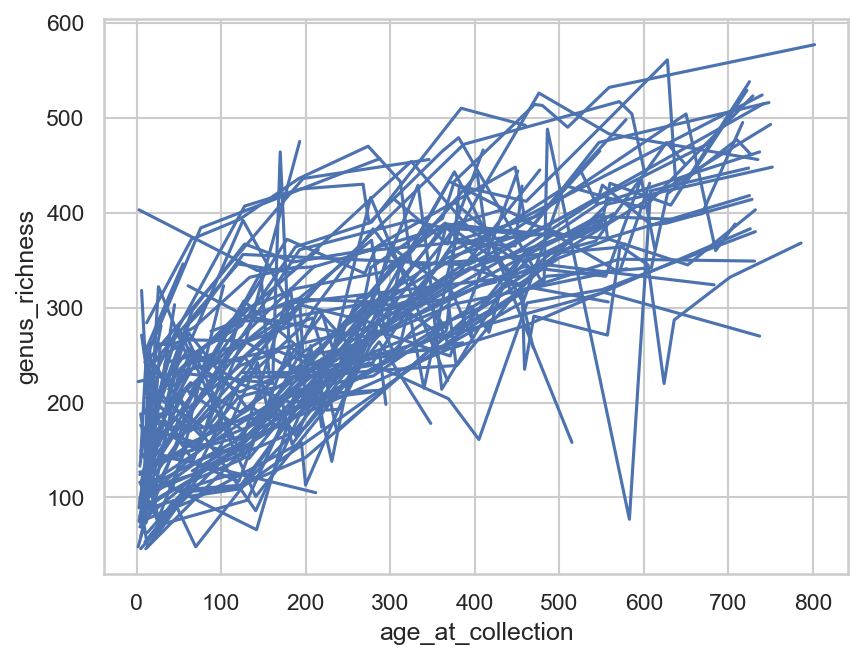

In [18]:
_ = sns.lineplot(x='age_at_collection', y='genus_richness', units='BabyN', estimator=None, markers=True, data=meta)

Definitely going up over time.

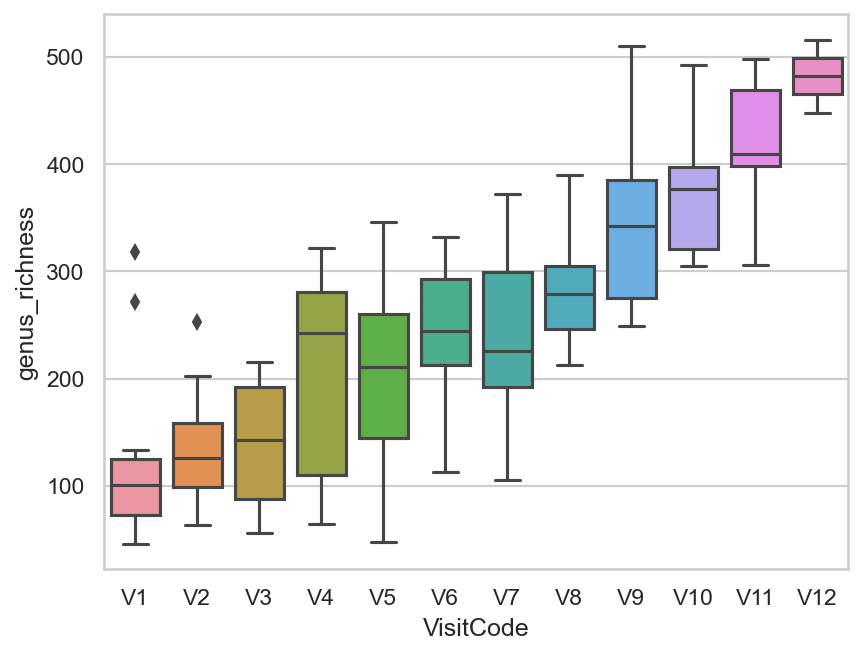

In [19]:
_ = sns.boxplot(x='VisitCode', y='genus_richness', data=meta.query("VisitCode in @visit_codes").query("BabyN not in @babies_w_abx").sort_values('age_at_collection'))

## Plot both richness and eveness together

Inspired by https://journals.asm.org/doi/10.1128/mSphere.01019-20

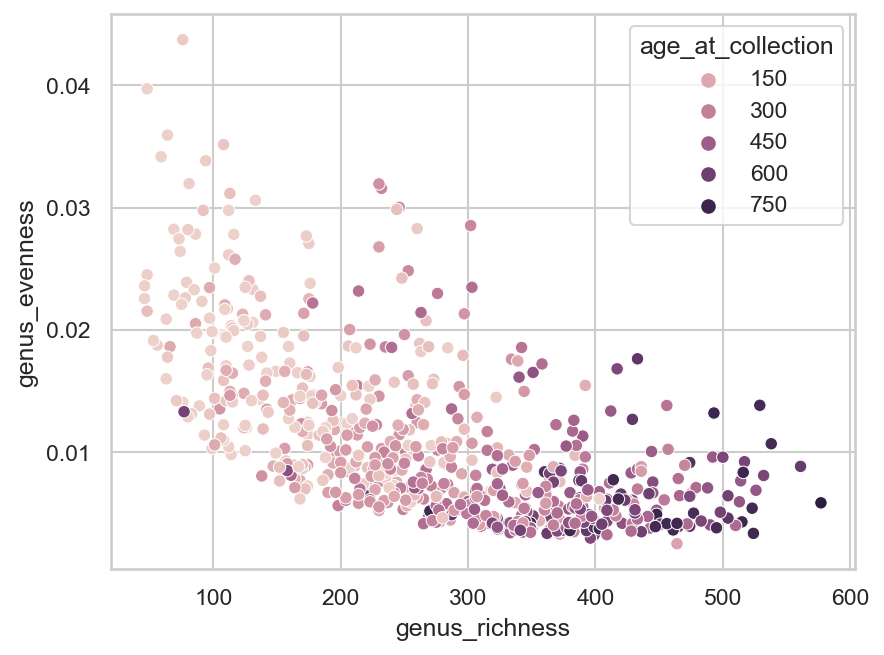

In [20]:
_ = sns.scatterplot(x='genus_richness', y='genus_evenness', hue='age_at_collection', data=meta)

Clear gradient across age. A decrease in evenness and increase in richness, as we saw in the plots of each diversity measure separately.

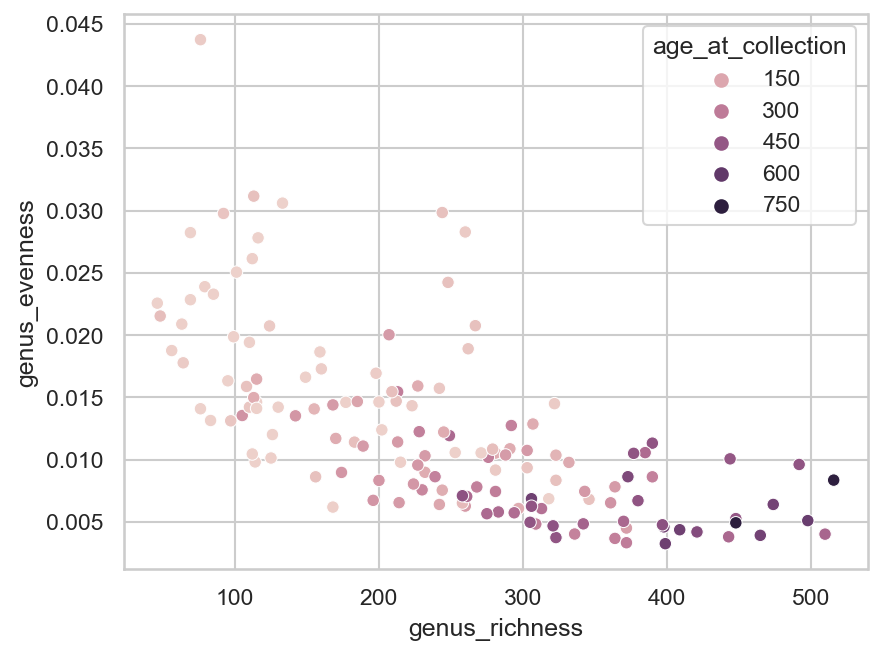

In [21]:
_ = sns.scatterplot(x='genus_richness', y='genus_evenness', hue='age_at_collection', data=meta.query("BabyN not in @babies_w_abx"))

Looking only at babies without antibiotics ever.

## Add vaccine outcome

Now instead of coloring the richness vs evenness plots by age we will color by vaccine response characteristics.

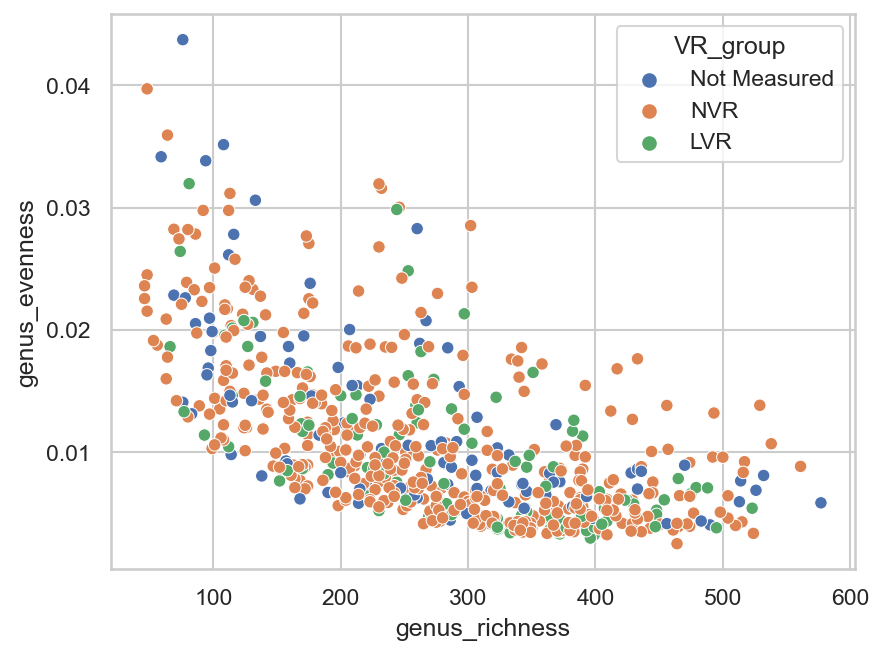

In [22]:
_ = sns.scatterplot(x='genus_richness', y='genus_evenness', hue='VR_group', data=meta)

No obvious clustering based on categorical responder status. Now we will highlight specific time points to see if there are patterns within certain time windows.

In [23]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
meta['2mo_sample'] = (meta['VisitCode'] == 'V5').astype(int)
meta['4mo_sample'] = meta['VisitCode'] == 'V6'
meta['6mo_sample'] = meta['VisitCode'] == 'V7'
meta['1yr_sample'] = meta['VisitCode'] == 'V9'
meta = meta.sort_values('VR_group')

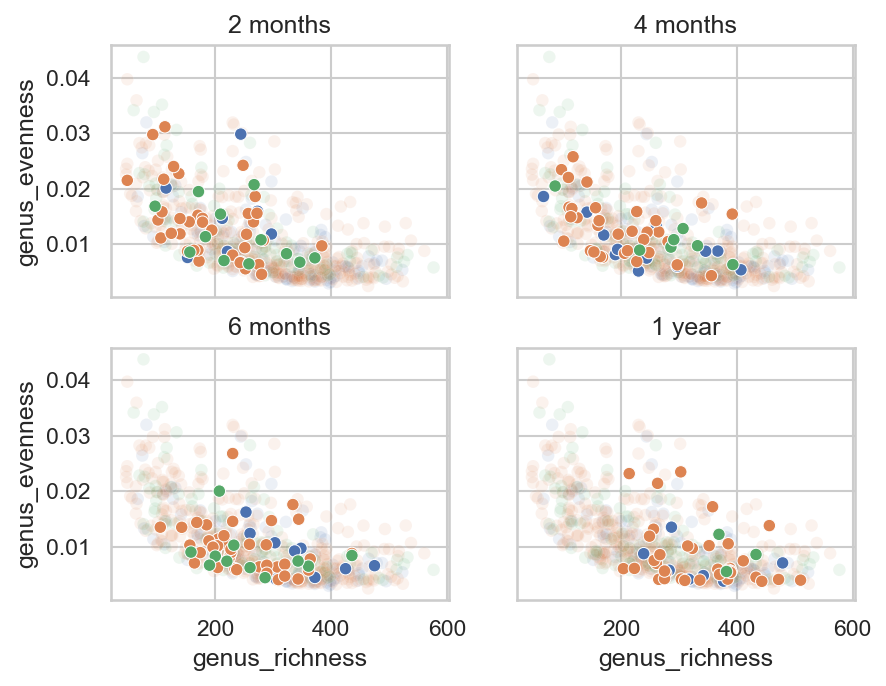

In [24]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

ax_simpson_2_months = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='VR_group',
                     data=meta.loc[meta['2mo_sample'] == 0], alpha=0.1, legend=False, ax=axs[0,0])
ax_simpson_2_months = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='VR_group',
                     data=meta[meta['2mo_sample'] == 1], alpha=1.0, legend=False, ax=axs[0,0])
# ax_simpson_2_months = legend_without_duplicate_labels(ax_simpson_2_months)
_ = ax_simpson_2_months.set_title('2 months')

ax_simpson_4_months = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='VR_group',
                     data=meta.loc[meta['4mo_sample'] == 0], alpha=0.1, legend=False, ax=axs[0,1])
ax_simpson_4_months = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='VR_group',
                     data=meta[meta['4mo_sample'] == 1], alpha=1.0, legend=False, ax=ax_simpson_4_months)
# ax_simpson_4_months = legend_without_duplicate_labels(ax_simpson_4_months)
_ = ax_simpson_4_months.set_title('4 months')

ax_simpson_6_months = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='VR_group',
                     data=meta.loc[meta['6mo_sample'] == 0], alpha=0.1, legend=False, ax=axs[1,0])
ax_simpson_6_months = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='VR_group',
                     data=meta[meta['6mo_sample'] == 1], alpha=1.0, legend=False, ax=ax_simpson_6_months)
# ax_simpson_6_months = legend_without_duplicate_labels(ax_simpson_6_months)
_ = ax_simpson_6_months.set_title('6 months')

ax_simpson_1_yr = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='VR_group',
                     data=meta.loc[meta['1yr_sample'] == 0], alpha=0.1, legend=False, ax=axs[1,1])
ax_simpson_1_yr = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='VR_group',
                     data=meta[meta['1yr_sample'] == 1], alpha=1.0, legend=False, ax=ax_simpson_1_yr)
# legend_without_duplicate_labels(ax_simpson_1_yr)
_ = ax_simpson_1_yr.set_title('1 year')

No clustering at important time points.

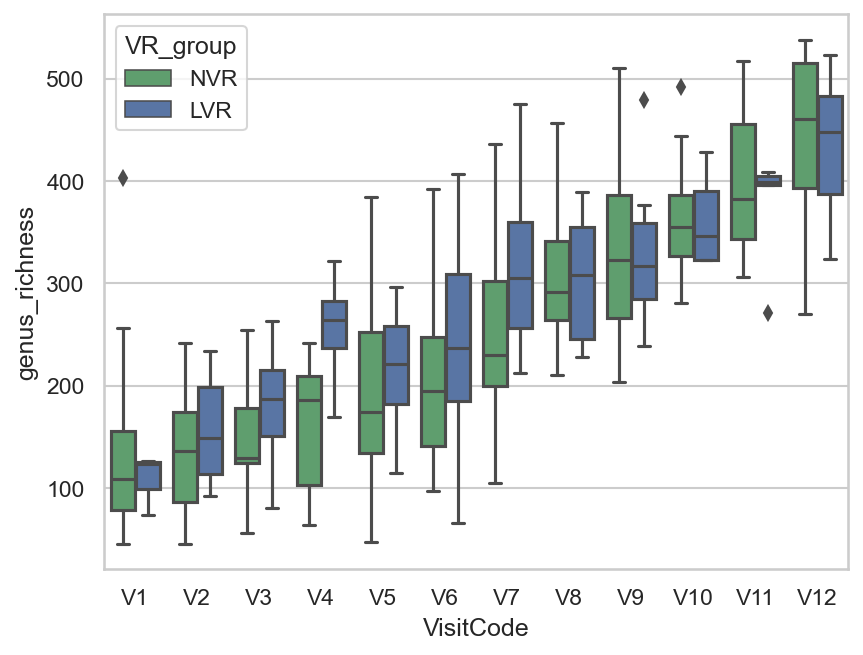

In [25]:
visit_codes = [i for i in meta['VisitCode'] if i.startswith('V') and '_' not in i]
has_titers_and_normal_visits_only_meta = meta.query("VisitCode in @visit_codes and VR_group != 'Not Measured'").sort_values('age_at_collection')
_ = sns.boxplot(x='VisitCode', y='genus_richness', dodge=True, hue='VR_group',
                palette={'LVR': 'b', 'NVR': 'g', 'HVR': 'r'},
                data=has_titers_and_normal_visits_only_meta)

Comparing richness between low and normal responders across healthy visits.

In [26]:
for visit_code, visit_frame in has_titers_and_normal_visits_only_meta.groupby('VisitCode'):
    lvr_values = visit_frame.loc[visit_frame['VR_group'] == 'LVR', 'genus_richness'].values
    nvr_values = visit_frame.loc[visit_frame['VR_group'] == 'NVR', 'genus_richness'].values
    print(visit_code, len(lvr_values), len(nvr_values), mannwhitneyu(lvr_values, nvr_values))

V1 3 20 MannwhitneyuResult(statistic=30.0, pvalue=1.0)
V10 9 23 MannwhitneyuResult(statistic=103.5, pvalue=1.0)
V11 5 22 MannwhitneyuResult(statistic=49.5, pvalue=0.7549329610087775)
V12 6 15 MannwhitneyuResult(statistic=39.0, pvalue=0.6768391567153177)
V2 6 33 MannwhitneyuResult(statistic=120.0, pvalue=0.4248225619691003)
V3 4 18 MannwhitneyuResult(statistic=49.0, pvalue=0.2866153858707573)
V4 4 11 MannwhitneyuResult(statistic=38.0, pvalue=0.03956043956043956)
V5 7 36 MannwhitneyuResult(statistic=152.0, pvalue=0.40144304315140744)
V6 12 33 MannwhitneyuResult(statistic=253.0, pvalue=0.1618266803223568)
V7 11 39 MannwhitneyuResult(statistic=321.0, pvalue=0.013036856176865126)
V8 6 31 MannwhitneyuResult(statistic=90.0, pvalue=0.9179496283771376)
V9 7 35 MannwhitneyuResult(statistic=122.0, pvalue=1.0)


So using a Mann-Whitney U only V7 is significantly different between the time points and in this case the LVR group has higher richness which is against our prediction.

In [27]:
titer_assoc_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['genus_richness', 'genus_evenness', 'genus_shannon']:
        N_LVR = len(meta.query("VisitCode == @timepoint & VR_group == 'LVR'"))
        N_NVR = len(meta.query("VisitCode == @timepoint & VR_group == 'NVR'"))
        if N_LVR > 2 and N_NVR > 2:
            w_value, p_value = mannwhitneyu(meta.query("VisitCode == @timepoint & VR_group == 'LVR'")[div_metric].values,
                                            meta.query("VisitCode == @timepoint & VR_group == 'NVR'")[div_metric].values)
            titer_assoc_rows.append([timepoint, div_metric, 'LVR/NVR', N_LVR, N_NVR, w_value, p_value])
titer_assocs = pd.DataFrame(titer_assoc_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'stat', 'p_value']).sort_values('p_value')
titer_assocs.head()

,timepoint,div_metric,titer_measure,N_LVR,N_NVR,stat,p_value
27,V7,genus_richness,LVR/NVR,11,39,321.0,0.013037
23,V11,genus_shannon,LVR/NVR,5,22,18.0,0.019051
18,V4,genus_richness,LVR/NVR,4,11,38.0,0.039560
22,V11,genus_evenness,LVR/NVR,5,22,22.0,0.039663
29,V7,genus_shannon,LVR/NVR,11,39,298.0,0.051918


### Continuous titers

It's the same thing as categorical titers.

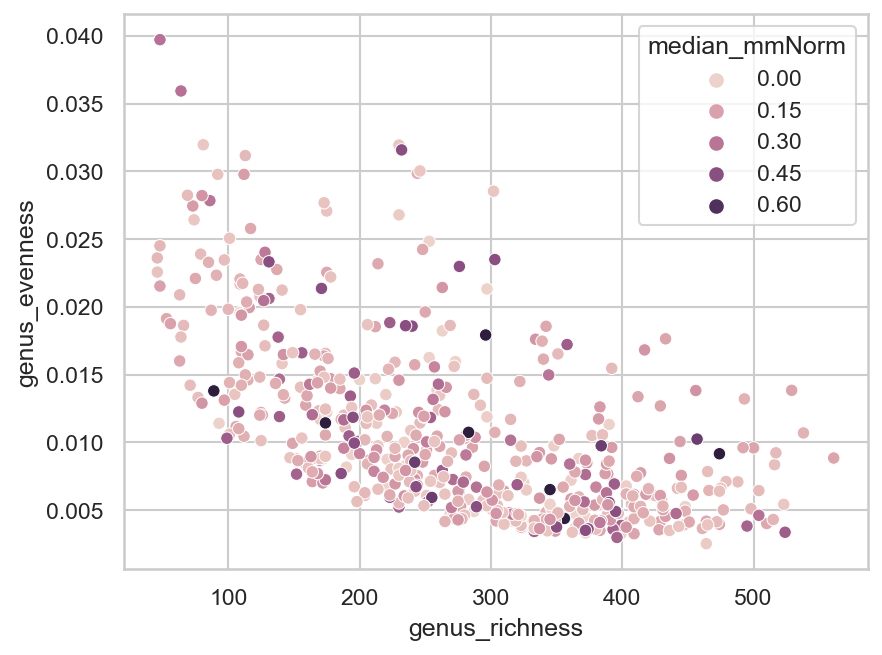

In [28]:
_ = sns.scatterplot(x='genus_richness', y='genus_evenness', hue='median_mmNorm', data=meta)

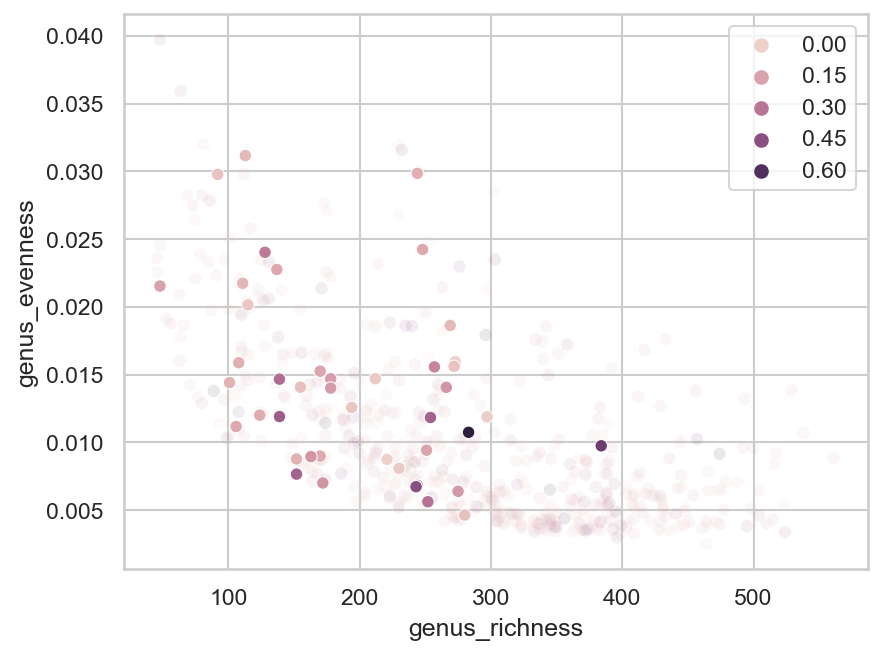

In [29]:
ax = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='median_mmNorm',
                     data=meta.loc[meta['2mo_sample'] == 0], alpha=0.1, hue_norm=(0, meta['median_mmNorm'].max()))
ax = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='median_mmNorm',
                     data=meta[meta['2mo_sample'] == 1], alpha=1.0, ax=ax, hue_norm=(0, meta['median_mmNorm'].max()))
legend_without_duplicate_labels(ax)

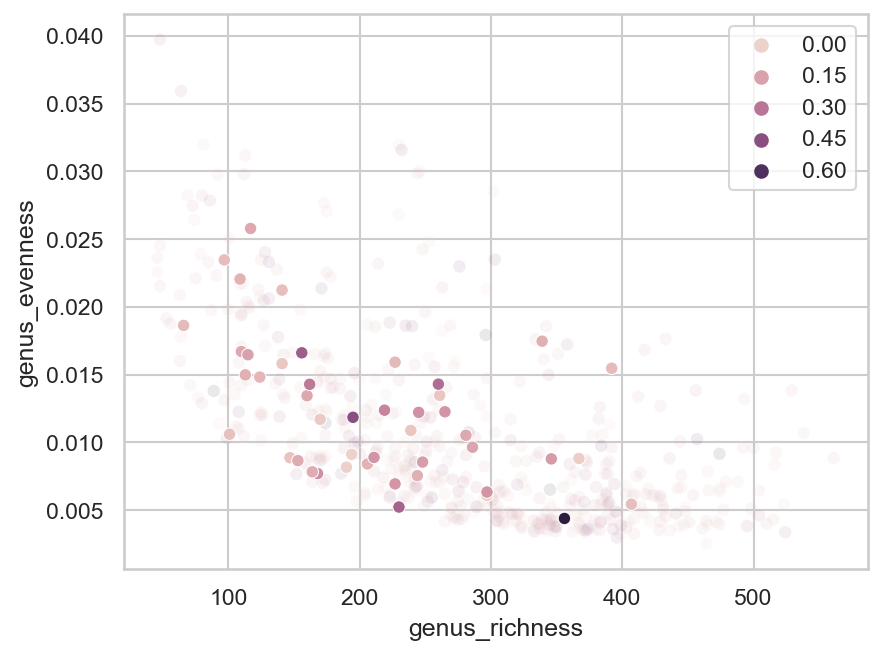

In [30]:
ax = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='median_mmNorm',
                     data=meta.loc[meta['4mo_sample'] == 0], alpha=0.1, hue_norm=(0, meta['median_mmNorm'].max()))
ax = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='median_mmNorm',
                     data=meta[meta['4mo_sample'] == 1], alpha=1.0, ax=ax, hue_norm=(0, meta['median_mmNorm'].max()))
legend_without_duplicate_labels(ax)

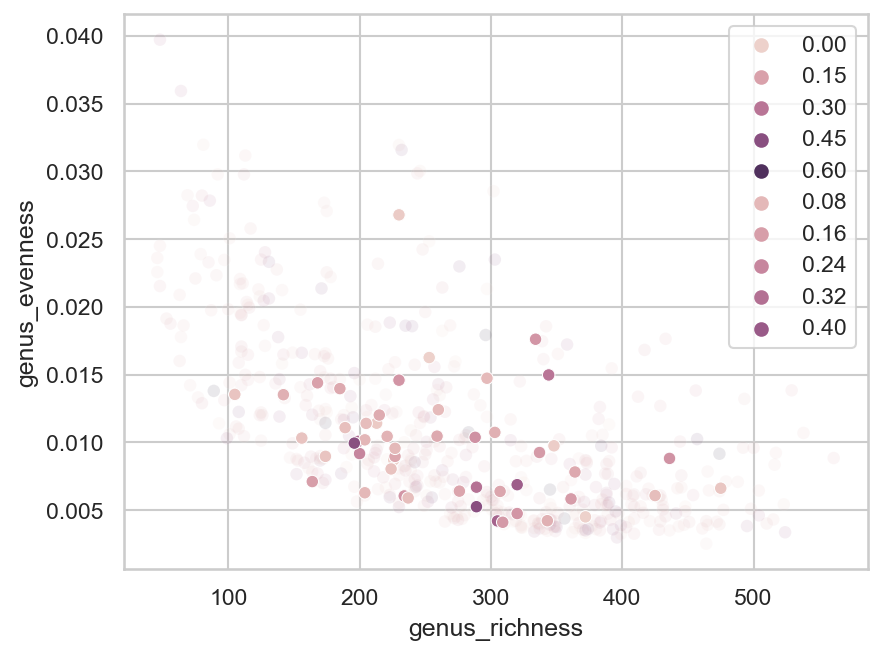

In [31]:
ax = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='median_mmNorm',
                     data=meta.loc[meta['6mo_sample'] == 0], alpha=0.1, hue_norm=(0, meta['median_mmNorm'].max()))
ax = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='median_mmNorm',
                     data=meta[meta['6mo_sample'] == 1], alpha=1.0, ax=ax, hue_norm=(0, meta['median_mmNorm'].max()))
legend_without_duplicate_labels(ax)

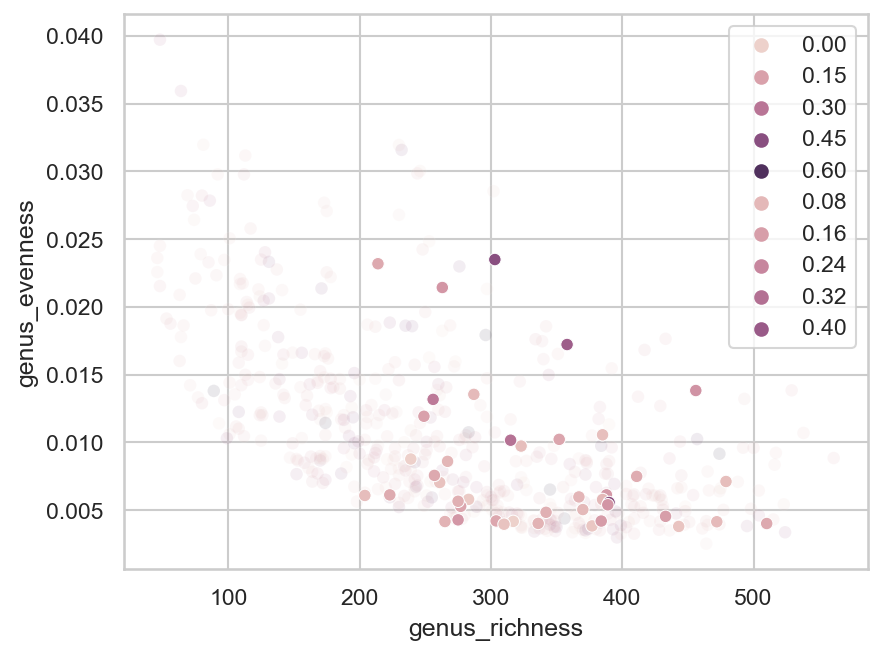

In [32]:
ax = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='median_mmNorm',
                     data=meta.loc[meta['1yr_sample'] == 0], alpha=0.1, hue_norm=(0, meta['median_mmNorm'].max()))
ax = sns.scatterplot(x="genus_richness", y="genus_evenness", hue='median_mmNorm',
                     data=meta[meta['1yr_sample'] == 1], alpha=1.0, ax=ax, hue_norm=(0, meta['median_mmNorm'].max()))
legend_without_duplicate_labels(ax)

These plots are ugly and the comparison between faded and not faded points are probably misleading but the results remain the same: no strong clusters by continuous titer.

In [33]:
titer_correls_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['genus_richness', 'genus_evenness', 'genus_shannon']:
        for titer_measure in ['median_mmNorm', 'median_mmNorm_DTAPHib', 'median_mmNorm_PCV']:
            N = len(meta.query("VisitCode == @timepoint")[titer_measure].dropna())
            if N > 3:
                r_value, p_value = spearmanr(meta.query("VisitCode == @timepoint")[div_metric].values,
                                             meta.query("VisitCode == @timepoint")[titer_measure].values,
                                             nan_policy='omit')
                titer_correls_rows.append([timepoint, div_metric, titer_measure, N, r_value, p_value])
titer_correls = pd.DataFrame(titer_correls_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N', 'R', 'p_value']).sort_values('p_value')
titer_correls.head()

,timepoint,div_metric,titer_measure,N,R,p_value
31,V5,genus_evenness,median_mmNorm_DTAPHib,43,-0.501134,0.000619
78,V9,genus_shannon,median_mmNorm,42,0.355968,0.020686
75,V9,genus_evenness,median_mmNorm,42,0.345434,0.025053
58,V4,genus_evenness,median_mmNorm_DTAPHib,15,-0.571429,0.026063
57,V4,genus_evenness,median_mmNorm,15,-0.553571,0.032287


In [34]:
titer_correls.query('p_value < .05')

,timepoint,div_metric,titer_measure,N,R,p_value
31,V5,genus_evenness,median_mmNorm_DTAPHib,43,-0.501134,0.000619
78,V9,genus_shannon,median_mmNorm,42,0.355968,0.020686
75,V9,genus_evenness,median_mmNorm,42,0.345434,0.025053
58,V4,genus_evenness,median_mmNorm_DTAPHib,15,-0.571429,0.026063
57,V4,genus_evenness,median_mmNorm,15,-0.553571,0.032287


In [35]:
col_order = ['body_site', 'timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'N', 'stat', 'R', 'p_value']
all_titer_stats = pd.concat([titer_assocs, titer_correls]).sort_values('p_value')
all_titer_stats['body_site'] = 'stool'
all_titer_stats = all_titer_stats[col_order]
all_titer_stats.head()

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
31,stool,V5,genus_evenness,median_mmNorm_DTAPHib,NaN,NaN,43.0,NaN,-0.501134,0.000619
27,stool,V7,genus_richness,LVR/NVR,11.0,39.0,NaN,321.0,NaN,0.013037
23,stool,V11,genus_shannon,LVR/NVR,5.0,22.0,NaN,18.0,NaN,0.019051
78,stool,V9,genus_shannon,median_mmNorm,NaN,NaN,42.0,NaN,0.355968,0.020686
75,stool,V9,genus_evenness,median_mmNorm,NaN,NaN,42.0,NaN,0.345434,0.025053


## Antibiotics

Now we will paint antibiotics information onto the richness vs evenness plots.

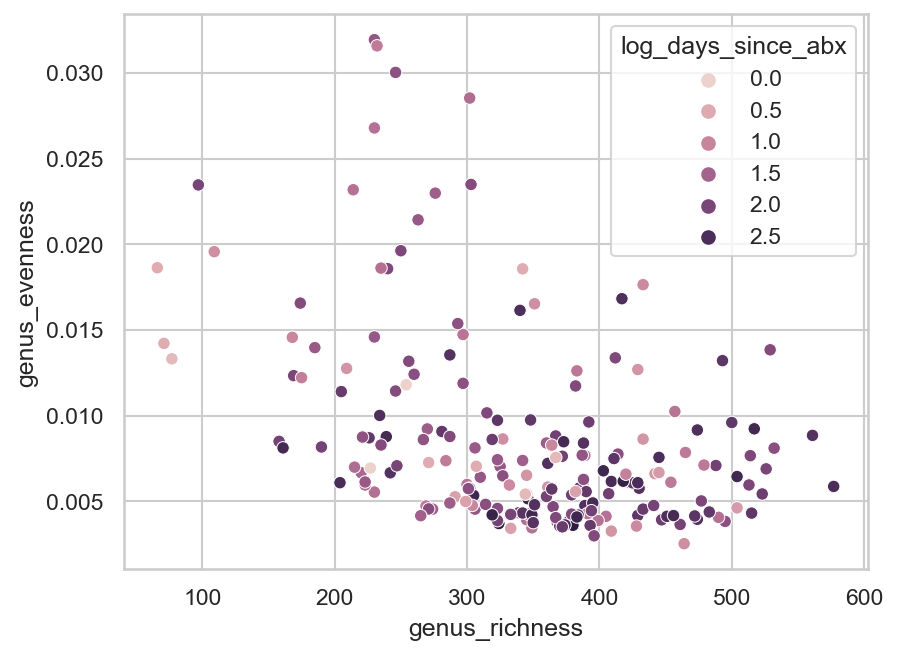

In [36]:
meta['log_days_since_abx'] = np.log10(meta['days_since_abx_end'])
_ = sns.scatterplot(x='genus_richness', y='genus_evenness', hue='log_days_since_abx', data=meta)

I'm not totally sure why so many points are missing from this. I assume it is because something weird happened with logging days since abx. Maybe all the zeros when to NA's and aren't displayed?

Either way, no clear pattern were recent abx points return to a infant like state (upper left of graph).

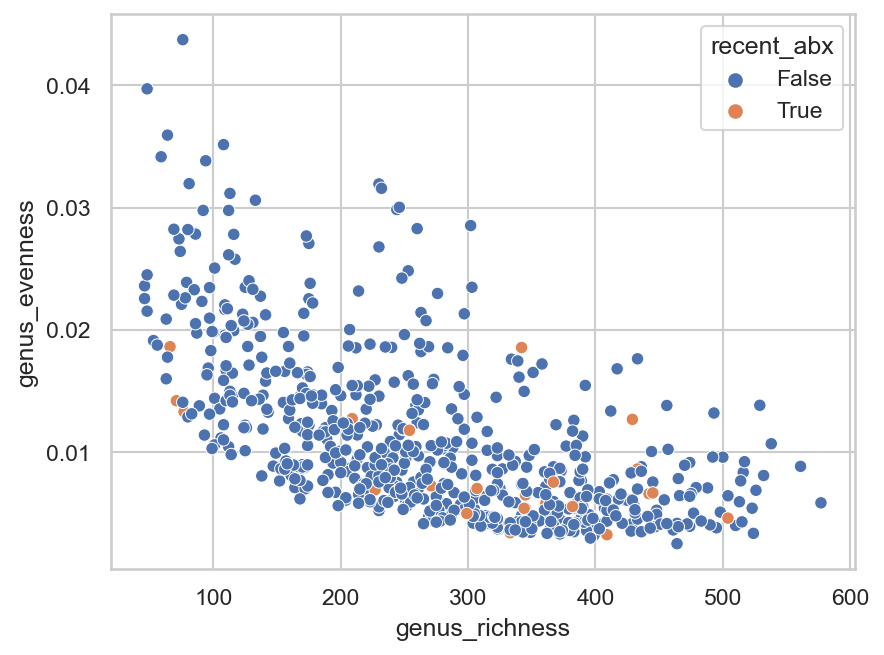

In [37]:
meta['recent_abx'] = meta['days_since_abx_end'] < 7
_ = sns.scatterplot(x='genus_richness', y='genus_evenness', hue='recent_abx', data=meta)

No pattern. We would hope to see points with recent abx looking like they move up and to the left. Maybe 7 is too many days?

## Change in alpha diversity with abx

The most common finding in papers associating the gut microbiome with antibiotics is a decrease in richness after treatment. We will now try to replicate that from our data.

First read in the antibiotics data.

In [38]:
abx_class = pd.read_csv('../../data/metadata/antibiotic_details.csv', index_col=0)
abx_class.head()

,Name for analysis,Class,Route of administration,Spectrum,Gram+/Gram-,# times in data,Reason_1,Route_1,Reason_2,Route_2,Reason_3,Route_3
Antibiotic,,,,,,,,,,,,
amoxicillin,amoxicillin,penicillin,oral,broad,NaN,61,NaN,NaN,NaN,NaN,NaN,NaN
amoxicillin clavulanate,amoxicillin clavulanate,penicillin,oral,broad,NaN,44,NaN,NaN,NaN,NaN,NaN,NaN
ampicillin,ampicillin,penicillin,IV,narrow,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
azithromycin,azithromycin,macrolide,oral,broad,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
bacitracin,bacitracin,polypeptide,topical,narrow,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN


Below we are generating a table that has all antibiotics usage information. Rows are specific cases where antibiotics have been administered.

We add to the existing table. We add route of administration from the abx class table. We are ignoring the "see reason column" route for now. Adding would only give a few extra courses. We also do some name and babyN normalization for easier comparison between tables. Then we determine the babies age at the start and end of the antibiotics course. This will be important for identifying stool samples that came before or after treatment.

In [39]:
abx = pd.read_csv('../../data/metadata/antibiotic_usage.tsv', sep='\t', index_col=0)
abx['BabyN'] = [int(i.split('Baby')[1]) for i in abx['BabyN']]
abx['cleaned_name'] = [abx_class.loc[i, 'Name for analysis'] for i in abx['Name']]
abx['route'] = [abx_class.loc[i, 'Route of administration'] for i in abx['Name']]
age_at_start = list() # get age of baby at start and end of abx
age_at_end = list()
for i, row in abx.iterrows():
    babyN = row['BabyN']
    baby_frame = meta.query('BabyN == @babyN')
    if len(baby_frame) == 0:
        age_at_start.append('???')
        age_at_end.append('???')
    else:
        dob =  pd.to_datetime(baby_frame.iloc[0]['DOB'])
        if row['Start_Date'] == 'Not Documented':
            age_at_start.append(pd.NA)
        else:
            age_at_start.append((pd.to_datetime(row['Start_Date']) - dob).days)
        if row['End_Date'] == 'Not Documented':
            age_at_end.append(pd.NA)
        else:
            age_at_end.append((pd.to_datetime(row['End_Date']) - dob).days)
abx['age_at_start'] = age_at_start
abx['age_at_end'] = age_at_end
abx.head()

,BabyN,AntibioticN,Name,Reason,Start_Date,End_Date,Duration_(days),DateOfBirth,AgeAtStart,AgeAtEnd,Route,cleaned_name,route,age_at_start,age_at_end
PrimaryKey,,,,,,,,,,,,,,,
Baby134_Antibiotic1,134,1,piperacillin/ tazobactam,R/O sepsis,2018-11-26,2018-11-28,2,2018-11-22,4.0,6.0,IV,piperacillin/tazobactam,IV,4,6
Baby134_Antibiotic2,134,2,ampicillin,R/O sepsis,2018-11-26,2018-11-27,1,2018-11-22,4.0,5.0,IV,ampicillin,IV,4,5
Baby134_Antibiotic3,134,3,gentamicin,R/O sepsis,2018-11-26,2018-11-27,1,2018-11-22,4.0,5.0,IV,gentamicin,see reason column,4,5
Baby134_Antibiotic4,134,4,vancomycin,R/O sepsis,2018-11-26,2018-11-27,1,2018-11-22,4.0,5.0,IV,vancomycin,IV,4,5
Baby235_Antibiotic1,235,1,unknown anitbiotic(s),"R/O sepsis, later confirmed neg.",2018-06-19,Not Documented,Unknown,2018-06-13,6.0,NaN,NaN,unknown,NaN,6,<NA>


Now we are adding stool information to this table of antibiotics usage. We only consider oral, IV and IM antibiotics here. For each treatment we pull all stool samples that are recent to treatment start (<7 days before) and recent to treatment end (<7 days after). Then we also check if any of these pre-abx samples are themselves post-abx samples and therefore already effected by antibiotics. We also check if any of the pre- or postsamples are during abx treatment themselves (I don't know that this completely makes sense? Maybe it should only check the sample closest to the stool sample). We only proceed to add these abx treatments to our new table if they have a pre and postsample that meets these criteria.

Then we take the samples that meet the criteria that are closest to the start and end of treatment. From these we pull alpha diversity metrics as well as abx treatment information (start day, end day, course length).

In [40]:
recent_days = 7
# recent_days = 30
abx_rows = dict()
for baby, baby_frame in meta.groupby('BabyN'):  # for each baby
    all_postsamples = list()
    baby_frame = baby_frame.sort_values('age_at_collection')
    baby_abx = abx.query('BabyN == @baby') # get abx baby was on
    routes_to_keep = ['oral', 'IV', 'IM']
    baby_abx = baby_abx.query("route in @routes_to_keep") # get oral/IV only TODO: separate oral and IV from topical
    for baby_abx, abx_row in baby_abx.iterrows():
        # get samples within a set number of days before abx
        age_at_start = abx_row['age_at_start']
        min_age_prestart = age_at_start - recent_days
        presamples = baby_frame.query('age_at_collection <= @age_at_start and age_at_collection >= @min_age_prestart')
        # get samples within a set number of days after abx
        age_at_end = abx_row['age_at_end']
        max_age_postend = age_at_end + recent_days
        postsamples = baby_frame.query('age_at_collection >= @age_at_end and age_at_collection <= @max_age_postend')
        no_presamples_are_postsamples = len(set(presamples.index) & set(all_postsamples)) == 0
        if len(presamples) > 0 and len(postsamples) > 0 and no_presamples_are_postsamples and ~presamples['on_abx'].any() and ~postsamples['on_abx'].any():
            presample = presamples.sort_values('age_at_collection').index[-1]
            presample_age = presamples.loc[presample, 'age_at_collection']
            postsample = postsamples.sort_values('age_at_collection').index[0]
            postsample_age = postsamples.loc[postsample, 'age_at_collection']
            # print(baby_abx, age_at_start, age_at_end, list(presamples.index), list(postsamples.index))
            abx_rows[baby_abx] = {'babyN': baby, 'start_date': abx_row['Start_Date'], 'start_age': age_at_start,
                                  'end_date': abx_row['End_Date'], 'end_age': age_at_end,
                                  'abx_length': int(abx_row['Duration_(days)']), 'presample': presample,
                                  'presample_age': presample_age,
                                  'presample_days_before_abx': age_at_start - presample_age,
                                  'presample_shannon': presamples.loc[presample, 'genus_shannon'],
                                  'presample_evenness': presamples.loc[presample, 'genus_evenness'],
                                  'presample_richness': presamples.loc[presample, 'genus_richness'],
                                  'postsample': postsample, 'postsample_age': postsample_age,
                                  'postsample_days_since_abx': postsample_age - age_at_end,
                                  'postsample_shannon': postsamples.loc[postsample, 'genus_shannon'],
                                  'postsample_evenness': postsamples.loc[postsample, 'genus_evenness'],
                                  'postsample_richness': postsamples.loc[postsample, 'genus_richness'],
                                  'delta_shannon': postsamples.loc[postsample, 'genus_shannon'] - presamples.loc[presample, 'genus_shannon'],
                                  'delta_evenness': postsamples.loc[postsample, 'genus_evenness'] - presamples.loc[presample, 'genus_evenness'],
                                  'delta_richness': postsamples.loc[postsample, 'genus_richness'] - presamples.loc[presample, 'genus_richness']}
        if len(postsamples) > 0:  # store post samples to check if a presample for a different pair
            all_postsamples += list(postsamples.index)
abx_alpha_div = pd.DataFrame(abx_rows).transpose()
print(len(abx_alpha_div))
abx_alpha_div.head()

5


,babyN,start_date,start_age,end_date,end_age,abx_length,presample,presample_age,presample_days_before_abx,presample_shannon,...,presample_richness,postsample,postsample_age,postsample_days_since_abx,postsample_shannon,postsample_evenness,postsample_richness,delta_shannon,delta_evenness,delta_richness
Baby108_Antibiotic3,108.0,2019-06-27,456,2019-07-07,466,10,108_V10,456.0,0.0,1.196252,...,323,108_A1,470.0,4.0,1.242794,0.005263,291,0.046542,0.000683,-32
Baby201_Antibiotic1,201.0,2018-11-30,281,2018-12-10,291,10,201_A1,278.0,3.0,1.691626,...,371,201_AF1,294.0,3.0,1.442949,0.007261,271,-0.248676,0.001652,-100
Baby202_Antibiotic1,202.0,2018-07-26,149,2018-08-02,156,7,202_S1,147.0,2.0,1.879296,...,337,202_V6,157.0,1.0,1.18192,0.006938,227,-0.697376,0.001055,-110
Baby227_Antibiotic3,227.0,2019-03-29,333,2019-04-08,343,10,227_A1,333.0,0.0,1.807114,...,429,227_A1F,346.0,3.0,3.40297,0.018567,342,1.595857,0.014398,-87
Baby241_Antibiotic4,241.0,2019-05-03,313,2019-05-13,323,10,241_S2,312.0,1.0,2.716143,...,433,241_S2F,325.0,2.0,1.785688,0.005417,344,-0.930455,-0.001577,-89


In [41]:
print(abx_alpha_div['presample_richness'].median())
print(abx_alpha_div['postsample_richness'].median())

371.0
291.0


After all of these filters we end up with only treatments where we have appropriate pre- and post-abx treatment samples.

In [42]:
print('shannon', wilcoxon(abx_alpha_div['delta_shannon']))
print('evenness', wilcoxon(abx_alpha_div['delta_evenness']))
print('richness', wilcoxon(abx_alpha_div['delta_richness']))

shannon WilcoxonResult(statistic=6.0, pvalue=0.8125)
evenness WilcoxonResult(statistic=3.0, pvalue=0.3125)
richness WilcoxonResult(statistic=0.0, pvalue=0.0625)


We cannot reach significance even though in the case of richness all values are less than 0.

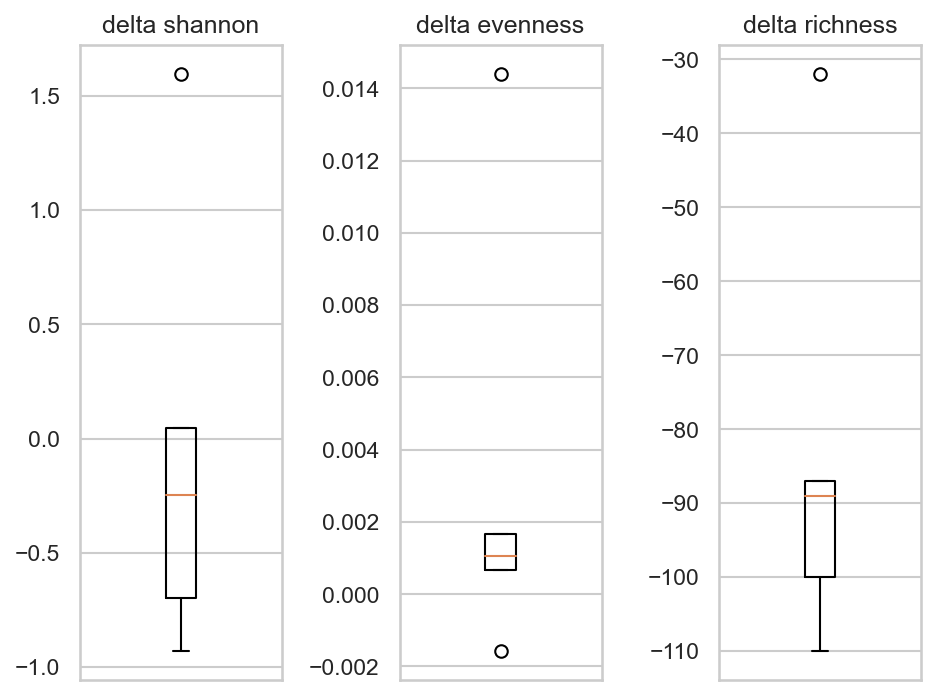

In [43]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.boxplot(abx_alpha_div['delta_shannon'])
ax1.set_title('delta shannon')
ax1.axes.get_xaxis().set_visible(False)

ax2.boxplot(abx_alpha_div['delta_evenness'])
ax2.set_title('delta evenness')
ax2.axes.get_xaxis().set_visible(False)

ax3.boxplot(abx_alpha_div['delta_richness'])
ax3.set_title('delta richness')
ax3.axes.get_xaxis().set_visible(False)

plt.tight_layout()

The most signal is in richness as we would expect. 

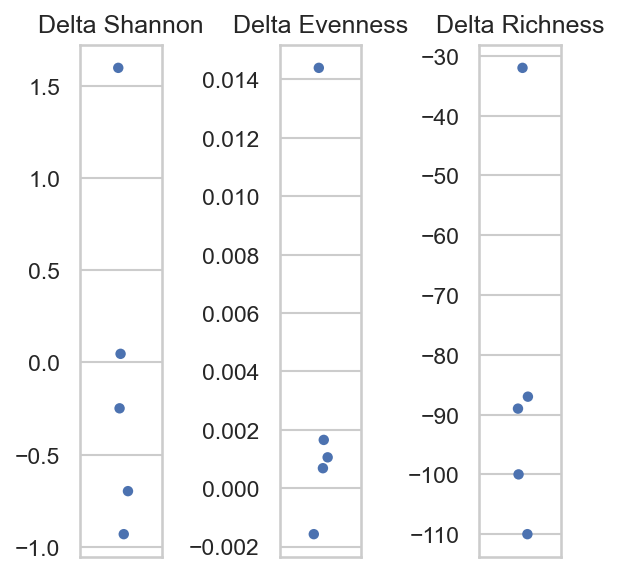

In [44]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4, 4))

sns.stripplot(y='delta_shannon', data=abx_alpha_div, ax=ax1)
ax1.set_title('Delta Shannon')
ax1.set(ylabel=None)

sns.stripplot(y='delta_evenness', data=abx_alpha_div, ax=ax2)
ax2.set_title('Delta Evenness')
ax2.set(ylabel=None)

sns.stripplot(y='delta_richness', data=abx_alpha_div, ax=ax3)
ax3.set_title('Delta Richness')
ax3.set(ylabel=None)

plt.tight_layout()

In [45]:
abx_alpha_div_longer_rows = list()
for baby_abx, row in abx_alpha_div.iterrows():
    abx_alpha_div_longer_rows.append([baby_abx, row['babyN'], row['presample'], row['start_age'], 'presample',
                                      row['presample_shannon'], row['presample_evenness'], row['presample_richness'],
                                      row['abx_length']])
    abx_alpha_div_longer_rows.append([baby_abx, row['babyN'], row['postsample'], row['start_age'], 'postsample',
                                      row['postsample_shannon'], row['postsample_evenness'], row['postsample_richness'],
                                      row['abx_length']])
abx_alpha_div_longer = pd.DataFrame(abx_alpha_div_longer_rows,
                                    columns=['baby_abx', 'babyN', 'sample', 'age', 'sample_type', 'shannon_div',
                                             'evenness_div', 'richness_div', 'duration'])
abx_alpha_div_longer.head()

,baby_abx,babyN,sample,age,sample_type,shannon_div,evenness_div,richness_div,duration
0,Baby108_Antibiotic3,108.0,108_V10,456,presample,1.196252,0.004580,323,10
1,Baby108_Antibiotic3,108.0,108_A1,456,postsample,1.242794,0.005263,291,10
2,Baby201_Antibiotic1,201.0,201_A1,281,presample,1.691626,0.005609,371,10
3,Baby201_Antibiotic1,201.0,201_AF1,281,postsample,1.442949,0.007261,271,10
4,Baby202_Antibiotic1,202.0,202_S1,149,presample,1.879296,0.005883,337,7


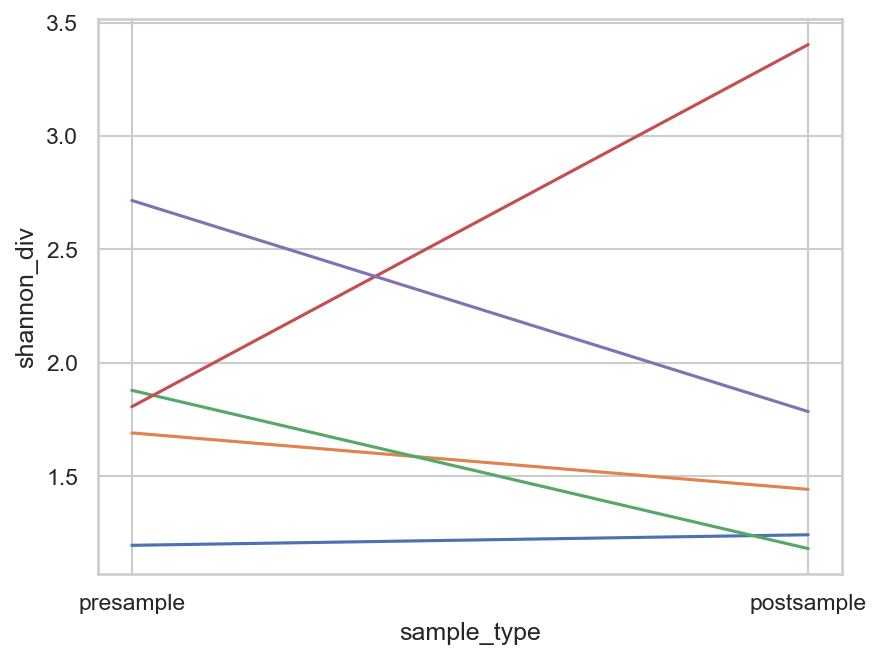

In [46]:
_ = sns.lineplot(x='sample_type', y='shannon_div', hue='baby_abx', data=abx_alpha_div_longer, legend=False)

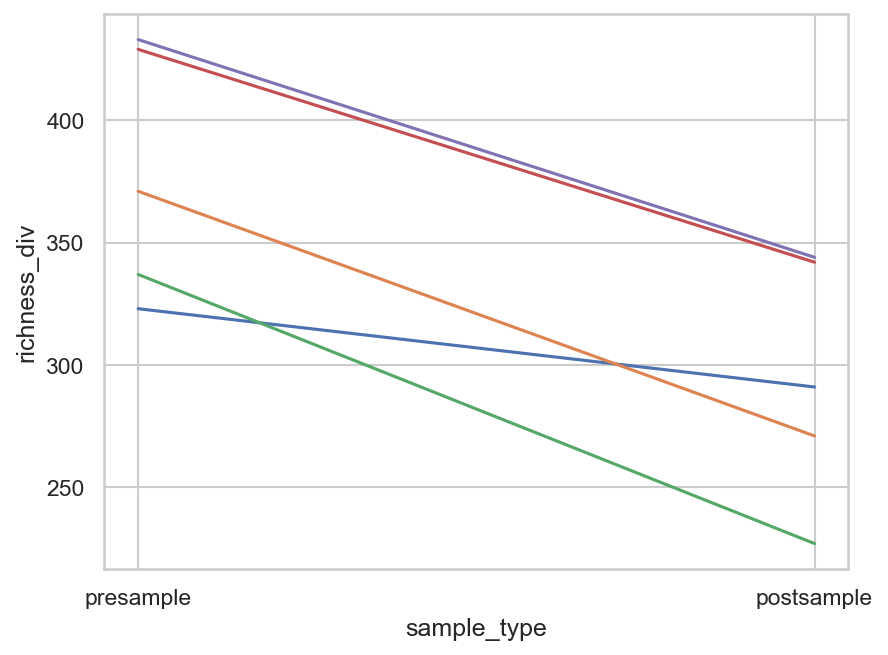

In [47]:
_ = sns.lineplot(x='sample_type', y='richness_div', hue='baby_abx', data=abx_alpha_div_longer.query('duration >= 7'), legend=False)

We can see in the line plots how richness decreases for all babies.